# Forudsigelse af tidsserier
I denne notebook ses på hvordan tidserier som f.eks. sensordata med sæsonmæssig variation kan forudsiges ved hjælp af [Prophet](https://facebook.github.io/prophet/). Prophet er en ikke lineær model som tager højde for tendens, sæson og feriedage. Notebooken er opdelt i tre dele: input, model og output hvor data henholdsvis klargøres, hældes ind i forudsigelsesmodellen og eksporteres til f.eks. CSV eller en PostgreSQL database.
1. [Input](#Input)
2. [Model](#Model)
3. [Output](#Output)

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

Forbindelse til postgres

In [3]:
import sys
sys.path.append('/Users/andersbarfod/Documents/python/')
import connections as con

# Input

Indlæser CSV og tileretter data til model input

In [4]:
df = pd.read_csv('temp.csv')

In [5]:
# Sorter kolonner
df = df.sort_values('date')
# Drop index kolonne
df.drop('Unnamed: 0', axis=1, inplace=True)
# Omdøb kolonner
df.columns = ['ds', 'y']
# Lav tidsstempel til datetime format
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d %H:%M:%S')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20327 entries, 10764 to 11224
Data columns (total 2 columns):
ds    20327 non-null datetime64[ns]
y     20327 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 476.4 KB


# Model

In [6]:
m = Prophet()
m.fit(df)

/Users/andersbarfod/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Laver tidserie som rækker en uge længere end data datasættet

In [7]:
future = m.make_future_dataframe(periods=168, freq='H')

Laver præriktion

In [8]:
forecast = m.predict(future)

In [9]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-02-01 00:00:00,3.369324,-0.063356,7.169295
1,2016-02-01 01:00:00,3.158063,-0.330348,6.728632
2,2016-02-01 02:00:00,2.985655,-0.997332,6.683529
3,2016-02-01 03:00:00,2.796479,-1.027880,6.296030
4,2016-02-01 04:00:00,2.618399,-1.300551,6.454349


### Visalisering

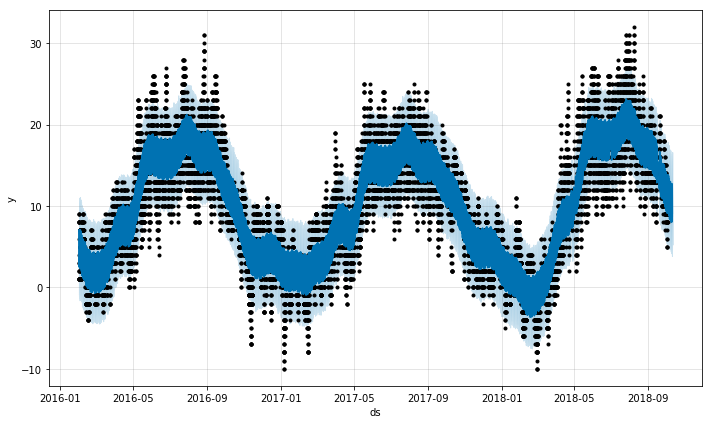

In [86]:
fig1 = m.plot(forecast, uncertainty=True)

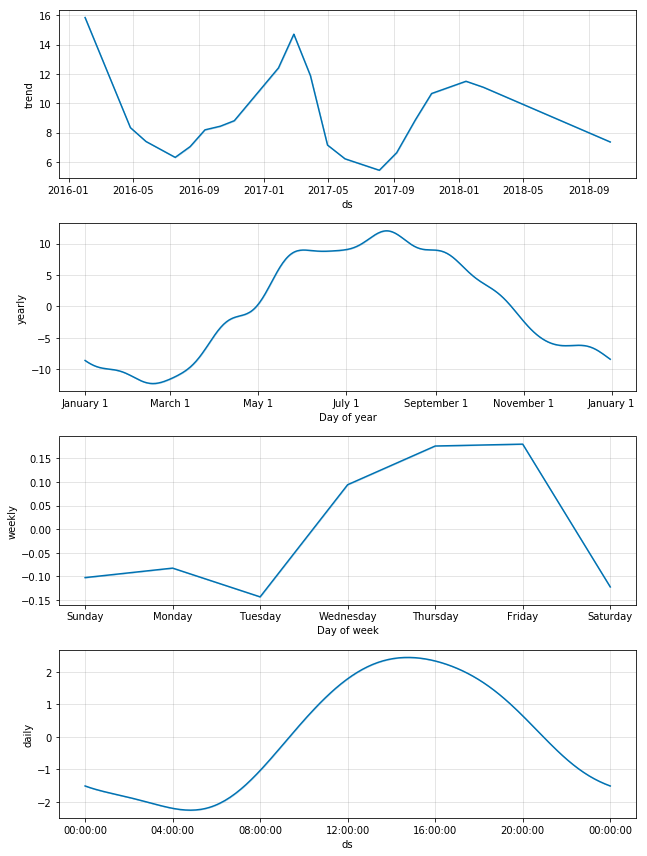

In [84]:
fig2 = m.plot_components(forecast)

### Merge

In [10]:
merge = df.merge(forecast, left_on='ds', right_on='ds', how='right')

In [11]:
merge.set_index('ds', inplace=True)

In [12]:
merge['diff'] = merge['y'] - merge['yhat']

In [13]:
merge[['y', 'yhat', 'diff']].head(100)

,y,yhat,diff
ds,,,
2016-02-01 00:00:00,1.0,3.369324,-2.369324
2016-02-01 01:00:00,1.0,3.158063,-2.158063
2016-02-01 02:00:00,1.0,2.985655,-1.985655
2016-02-01 03:00:00,2.0,2.796479,-0.796479
2016-02-01 04:00:00,1.0,2.618399,-1.618399
2016-02-01 05:00:00,1.0,2.549443,-1.549443
2016-02-01 06:00:00,1.0,2.693893,-1.693893
2016-02-01 07:00:00,1.0,3.096689,-2.096689
2016-02-01 08:00:00,1.0,3.720092,-2.720092


# Output

Sender data over til PostgreSQL

In [14]:
con = con.engine('distribution')

In [15]:
merge.columns

Index(['y', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'diff'],
      dtype='object')

Tager kun sidste 1000 rækker hvor prognosen indgår

In [17]:
merge[['y', 'yhat', 'diff', 'yhat_lower', 'yhat_upper']].tail(1000).to_sql('temperatur_forecast', con=con)